## Sentence Quality Classification

Classifiy sentences into high / low quality. This is used to improve data quality for texts from different sources (scanned PDFs, crawled HTML, parsed Wikipedia, ..). It's mainly used to filter out artifacts from faulty parsing, HTML fragments, navigation elements, non-sentences (references, titles, ..)

This notebook uses BERT for this task. Other approaches can be found in sentence_quality_classifier.ipynb

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import load_config
import json
import numpy as np

### define a new configuration
config_dict = {
    # training data
    "train_file": "data/sentence-quality-8k.csv",
    "seq_len": 128,
    "batch_size": 128,
    "epochs": 5,
    "lr": 1e-4,
    
    # where to store the configuration file
    "config_path": "data/configuration-sentence-quality-classifier-bert.json"
}

In [2]:
### save config file (don't change)
config_src = config_dict["config_path"]

with open(config_src, 'w+') as f:
    json.dump(config_dict, f, indent=4)
    
# load config object based on config file (don't change)
config = load_config.Configuration(config_src, True)

In [3]:
# load training data
import pandas as pd 

data = pd.read_csv(config['train_file']) 
data = data.sample(frac=1).reset_index(drop=True)

Number of sentences: 8007
Number of sentences with label: 8005


['LOW_QUALITY', 'REFERENCE', 'SENTENCE', 'TITLE', 'FOREIGN']

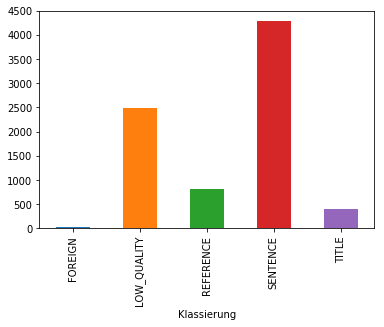

In [4]:
# set targets
print("Number of sentences: " + str(len(data.index)))
data = data.dropna(subset= ['Klassierung'])
print("Number of sentences with label: " + str(len(data.index)))
data.groupby('Klassierung').Klassierung.count().plot.bar()

#data['label'] = pd.Series(['high' if a else 'low' for a in data['Klassierung'].isin(['SENTENCE'])], index=data.index)
data['label'] = pd.Series(data['Klassierung'], index=data.index)

# set label / classes
classes = list(data['label'].unique())
data.head()
classes

In [19]:
# Load BERT model
from keras_bert import Tokenizer
import keras
from keras_bert import get_base_dict, get_model, gen_batch_inputs
from keras_bert import get_pretrained, PretrainedList, get_checkpoint_paths
import codecs
from keras_bert import load_trained_model_from_checkpoint

model_path = get_pretrained(PretrainedList.multi_cased_base)
paths = get_checkpoint_paths(model_path)
print(paths.config, paths.checkpoint, paths.vocab)

token_dict = get_base_dict()  # A dict that contains some special tokens
with codecs.open(paths.vocab, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)
        
print("Vocabulary size: " + str(len(token_dict)))

model = load_trained_model_from_checkpoint(
    paths.config,
    paths.checkpoint,
    training=True,
    trainable=False,
    seq_len=config["seq_len"],
)

/home/tim/.keras/datasets/multi_cased_L-12_H-768_A-12/bert_config.json /home/tim/.keras/datasets/multi_cased_L-12_H-768_A-12/bert_model.ckpt /home/tim/.keras/datasets/multi_cased_L-12_H-768_A-12/vocab.txt
Vocabulary size: 119548


In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
__________________________________________________________________________________________________
Embedding-

In [27]:
# Convert data
tokenizer = Tokenizer(token_dict)

indices = []
for sentence in data["Satz"]:
    ids, segments = tokenizer.encode(sentence, max_len=config["seq_len"])
    indices.append(ids)
indices = np.array(indices)
target_indices = np.array([1 if target=="SENTENCE" else 0 for target in data["label"]])

#train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(indices, target_indices, random_state = 2)

# input is an array of the token indices and an array of the segment indices
# (which is 0 for all tokens in this task)
segments_test = np.zeros_like(X_test)
segments_train = np.zeros_like(X_train)

In [28]:
# Build Custom Model / Add softmax layer for sentence classification on top
import keras
from keras_bert import AdamWarmup, calc_train_steps

inputs = model.inputs[:2]
dense = model.get_layer('NSP-Dense').output
outputs = keras.layers.Dense(units=2, activation='softmax')(dense)

decay_steps, warmup_steps = calc_train_steps(
    y_train.shape[0],
    batch_size=config["batch_size"],
    epochs=config["epochs"],
)

model = keras.models.Model(inputs, outputs)
model.compile(
    AdamWarmup(decay_steps=decay_steps, warmup_steps=warmup_steps, lr=config["lr"]),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)


In [29]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
__________________________________________________________________________________________________
Embedding-

In [30]:
model.fit(
    [X_train, segments_train],
    y_train,
    epochs=config["epochs"],
    batch_size=config["batch_size"]
)

Epoch 1/5
6003/6003 [==============================] - 38s 6ms/step - loss: 0.6930 - sparse_categorical_accuracy: 0.5317
Epoch 2/5
6003/6003 [==============================] - 36s 6ms/step - loss: 0.6890 - sparse_categorical_accuracy: 0.5376
Epoch 3/5
6003/6003 [==============================] - 37s 6ms/step - loss: 0.6893 - sparse_categorical_accuracy: 0.5354
Epoch 4/5
6003/6003 [==============================] - 37s 6ms/step - loss: 0.6872 - sparse_categorical_accuracy: 0.5491
Epoch 5/5
6003/6003 [==============================] - 37s 6ms/step - loss: 0.6864 - sparse_categorical_accuracy: 0.5542


In [31]:
predicts = model.predict([X_test, segments_test], verbose=True).argmax(axis=-1)
print(np.sum(y_test == predicts) / y_test.shape[0])

2002/2002 [==============================] - 14s 7ms/step
0.5469530469530469
